# 1. 1D Linear Convection

We consider the 1d linear Convection equation, under a constant velocity

$$
\partial_t u + c \partial_x u = 0
$$

If we denote $u_0(x) := u(x,t)$ then the exact solution is 
$$
u(x,t) = u_0(x-ct)
$$


## Using Finite Differences

our problem is then discretized as
$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 $$

In [1]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like
from matplotlib.pyplot import plot, show
%matplotlib inline

In [2]:
nx = 401  
dx = 2 / (nx-1)
T = 0.25  # T final time
dt = .0025  # time step 
c = 1      # wavespeed 
niter = int(2*T / dt)

In [3]:
# Initial condition
from numpy import exp
u0 = lambda x: exp(-(x-.3)**2/.05**2)

grid = linspace(0., 1., nx)
u = u0(grid) 

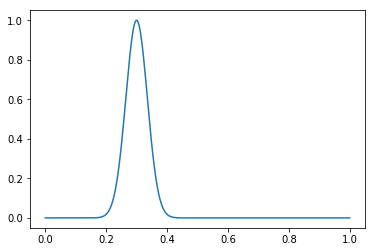

In [4]:
plot(grid, u) ; show()

In [5]:
un = zeros(nx)
for n in range(niter):  
    un[:] = u[:] 
    for i in range(1, nx): 
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])

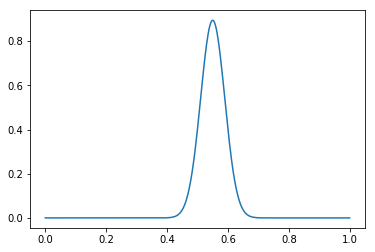

In [6]:
plot(grid, u) ; show()

## Using IGA

### Time scheme

$$\frac{u^{n+1}-u^n}{\Delta t} + c \partial_x u^{n+1} = 0 $$

$$ \left(I + c \Delta t \partial_x \right) u^{n+1} = u^n $$

### Weak formulation

$$
\langle v, u^{n+1} \rangle - c \Delta t ~ \langle \partial_x v, u^{n+1} \rangle = \langle v, u^n \rangle
$$
expending $u^n$ over the fem basis, we get the linear system

$$A U^{n+1} = M U^n$$

where

$$
M_{ij} = \langle b_i, b_j \rangle
$$

$$
A_{ij} = \langle b_i, b_j \rangle - c \Delta t ~ \langle \partial_x b_i, b_j \rangle
$$


In [7]:
# needed imports
from spl.linalg.stencil import StencilVector, StencilMatrix
from spl.core.interface import make_open_knots
from spl.fem.splines import SplineSpace
from scipy.sparse.linalg import cg, gmres
from utils import assemble_matrix_1d
from utils import assemble_rhs_1d

In [8]:
dt = 0.001
niter = int(T / dt)

p  = 3    # spline degree
ne = 64   # number of elements
n  = p + ne
    
# to be removed
knots = make_open_knots(p, n)

# create a finite element space
V = SplineSpace(knots, p)

In [9]:
# kernel for mass matrix
def kernel_M(p1, k1, basis, w, mat):
    mat[:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis[il_1, 0, g1]
                bi_x = basis[il_1, 1, g1]

                bj_0 = basis[jl_1, 0, g1]
                bj_x = basis[jl_1, 1, g1]

                wvol = w[g1]

                v += (bi_0 * bj_0) * wvol
            mat[il_1, p1 + jl_1 - il_1] = v
            
# kernel for A matrix
def kernel_A(p1, k1, basis, w, mat, c, dt):
    mat[:,:] = 0.
    for il_1 in range(0, p1+1):
        for jl_1 in range(0, p1+1):

            v = 0.0
            for g1 in range(0, k1):
                bi_0 = basis[il_1, 0, g1]
                bi_x = basis[il_1, 1, g1]

                bj_0 = basis[jl_1, 0, g1]
                bj_x = basis[jl_1, 1, g1]

                wvol = w[g1]

                v += (bi_0 * bj_0 - c * dt * bi_x * bj_0) * wvol
            mat[il_1, p1 + jl_1 - il_1] = v

In [10]:
M = assemble_matrix_1d(V, kernel_M).tocsr()
A = assemble_matrix_1d(V, kernel_A, args=(c, dt)).tocsr()

In [11]:
# L2 projection of u0
rhs = assemble_rhs_1d(V, u0).toarray()
un, status = cg(M, rhs, tol=1.e-8, maxiter=5000) 

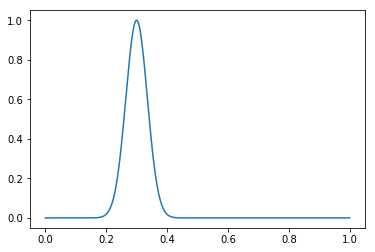

In [12]:
# TODO - to be replaced by the Field evaluation
#      - implement setfromarray 
from scipy.interpolate import splev
def evaluate_field(un, x):
    c_un = zeros_like(knots)
    c_un[:len(un)] = un[:]
    tck = (knots, un, p)
    y = splev( x, tck )
    return y

grid = linspace(0., 1., 401)
plot(grid, evaluate_field(un, grid)) ; show()

In [13]:
for i in range(0, niter):
    b = M.dot(un)
    un, status = gmres(A, b, tol=1.e-8, maxiter=5000)


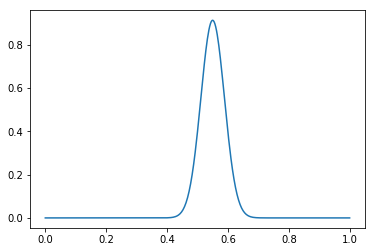

In [14]:
plot(grid, evaluate_field(un, grid)) ; show()

In [58]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()